In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold

# Fonctions utiles

In [2]:
#predictions[i,j] = categorie prédites par le i-ème classifieur pour l'individu j
def votes(predictions, categories, seuil=0.5):
    nb_individus = np.shape(predictions)[1]
    nb_classifieurs = np.shape(predictions)[0]
    res_votes = []
    
    for j in range(nb_individus):
        res_votes.append(vote(predictions[j], categories, nb_classifieurs, seuil))
    
    return res_votes

#Vote pour un seul individu
def vote(predictions, categories, nb_classifieurs, seuil = 0.5):
    nb_votes = np.zeros(len(categories))
    for i in range(nb_classifieurs):
        for c in range(len(categories)):
            if predictions[i] == categories[c]:
                nb_votes[c] +=1

    temp = []
    for c in range(len(categories)):
        if (nb_votes[c]/nb_classifieurs >= seuil):
            temp.append(categories[c])
    if temp == []:
        return [-1]
    else:
        return temp

# Chargement des données

In [3]:
satimage_data = pd.read_csv("dataset_186_satimage.csv")
satimage_categories = np.unique(satimage_data["class"])
y = satimage_data["class"]
X = satimage_data.drop(labels=["class"], axis=1)
satimage_data.head()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,...,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1.0
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5.0
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7.0
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3.0
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5.0


In [4]:
np.round(100*satimage_data["class"].value_counts()/np.shape(satimage_data)[0], 1)

1.0    23.8
7.0    23.5
3.0    21.1
5.0    11.0
2.0    10.9
4.0     9.7
Name: class, dtype: float64

In [5]:
cancer_data = pd.read_csv("phpAmSP4g.csv")
cancer_categories = np.unique(cancer_data["Class"])
cancer_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,2


In [6]:
np.round(100*cancer_data["Class"].value_counts()/np.shape(cancer_data)[0], 1)

1    62.7
2    37.3
Name: Class, dtype: float64

Les catégories sont deséquilibrées pour les deux jeux de données.

# Random Subspace Method

## Fonctions

In [7]:
class RSM:

    def __init__(self, dimension_subspaces, nb_subspaces=100, model = "decision_tree"):
        self.nb_subspaces = nb_subspaces
        self.dimension_subspaces = dimension_subspaces
        self.model = model
        self.pred = []
        self.trees = []
        self.subspaces = []
        
    def fit(self, train_data, y, max_depth=1):
        nrow = np.shape(train_data)[0]
        predictions = []
        variables_names = train_data.columns
        for i in range(self.nb_subspaces):
            if self.model == "decision_tree" :
                new_model = DecisionTreeClassifier(max_depth=max_depth)
            
            new_subspace = random.choices(variables_names, k=self.dimension_subspaces)
            self.subspaces.append(new_subspace)
            self.trees.append(new_model.fit(X = train_data[new_subspace], y=y))

    def predict(self, new_data, categories, seuil=0.5):
        self.pred = []
        count = 0
        for t in self.trees:
            self.pred.append(t.predict(new_data[self.subspaces[count]]))
            count+=1
        self.pred = pd.DataFrame(self.pred)
        return votes(self.pred, categories= categories, seuil=seuil)

## Un exemple de RSM

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
p = len(satimage_data.columns)
p

37

In [9]:
RSM_model = RSM(dimension_subspaces=int(p/2), nb_subspaces=100, model = "decision_tree")
RSM_model.fit(train_data = X_train, y = y_train, max_depth=1)
pred = RSM_model.predict(new_data= X_train, categories = satimage_categories, seuil = 0.51)
print(pred[1:10])

y_chap = np.array(pred)
acc_train = accuracy_score(y_train, y_chap)

pred = RSM_model.predict(new_data= X_test, categories = satimage_categories, seuil = 0.51)
y_chap = np.array(pred)
acc_test = accuracy_score(y_test, y_chap)

print("Accuracy on train data = %0.3f"%acc_train)
print("Accuracy on test data = %0.3f"%acc_test)

[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
Accuracy on train data = 0.429
Accuracy on test data = 0.417


Cette méthode semble bien fonctionner sur les données *cancer* et moins bien pour les données *satimage*.

## Étude du paramètre dimension_subspaces

## Satimage data

In [10]:
p = len(satimage_data.columns)
dims_subspaces = range(2,p,2)
acc = []
kf = StratifiedKFold(n_splits=5)
for d in dims_subspaces:
    acc_temp=[]
    for train_index, test_index in kf.split(X, y):
        RMS_model = RSM(dimension_subspaces=d, nb_subspaces=100, model = "decision_tree")
        train_temp = X.loc[train_index,]
        test_temp = X.loc[test_index,]
        y_train_temp = y[train_index]
        y_test_temp = y[test_index]
        
        RMS_model.fit(train_data = train_temp, y = y_train_temp, max_depth=1)
        pred = RMS_model.predict(new_data= test_temp, categories = satimage_categories, seuil = 0.51)
        y_chap = np.asarray(pred)
        acc_temp.append(accuracy_score(y_chap, y_test_temp))
    acc.append(acc_temp)

Meilleur dimension =   2 Accuracy moyenne = 0.563


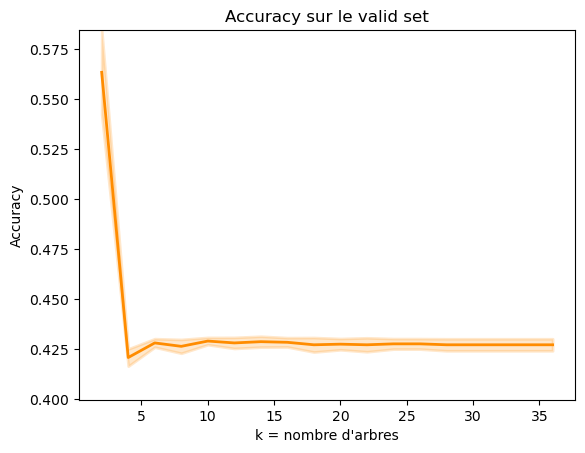

In [11]:
max_i = 0
max_acc = 0
min_acc = 1
mean_acc = []
std_acc = []
count=0
for i in range(2,p,2):
    new_acc = np.mean(acc[count])
    mean_acc.append(new_acc)
    new_std = np.std(acc[count])
    std_acc.append(new_std)
    if new_acc > max_acc:
        max_i = i
        max_acc = new_acc
    if new_acc < min_acc:
        min_acc = new_acc
    count+=1
print("Meilleur dimension = %3.0f Accuracy moyenne = %0.3f"%(max_i, max_acc))

mean_acc = np.double(mean_acc)
std_acc = np.double(std_acc)
plt.title("Accuracy sur le valid set")
plt.xlabel("k = nombre d'arbres")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
lw = 2
param_range = range(2,p,2)
plt.ylim(min_acc - np.max(std_acc), max_acc + np.max(std_acc))
plt.plot(
    param_range, mean_acc, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    mean_acc - std_acc,
    mean_acc + std_acc,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)

La meilleure valeur de l'hyperparamètre *nb_dimensions* semble être 2, ce qui est assez loin de la valeur conseillée qui est $\frac{p}{2}=18$. Cette valeur semble significativement meilleure que les autres.

## Cancer data

In [12]:
p = len(cancer_data.columns)
dims_subspaces = range(2,p,2)
acc = []
X = cancer_data.drop(labels=["Class"], axis=1)
y = np.array(cancer_data["Class"])
kf = StratifiedKFold(n_splits=5)
for d in dims_subspaces:
    acc_temp=[]
    for train_index, test_index in kf.split(X, y):
        RMS_model = RSM(dimension_subspaces=d, nb_subspaces=100, model = "decision_tree")
        train_temp = X.loc[train_index,]
        test_temp = X.loc[test_index,]
        y_train_temp = y[train_index]
        y_test_temp = y[test_index]
        
        RMS_model.fit(train_data = train_temp, y = y_train_temp, max_depth=1)
        #Seuil = 0.51 pour être sur d'avoir une seule prediction en sortie
        pred = RMS_model.predict(new_data= test_temp, categories = satimage_categories, seuil = 0.51)
        
        acc_temp.append(accuracy_score(pred, y_test_temp))
    acc.append(acc_temp)



Meilleur dimension =   2 Accuracy moyenne = 0.932


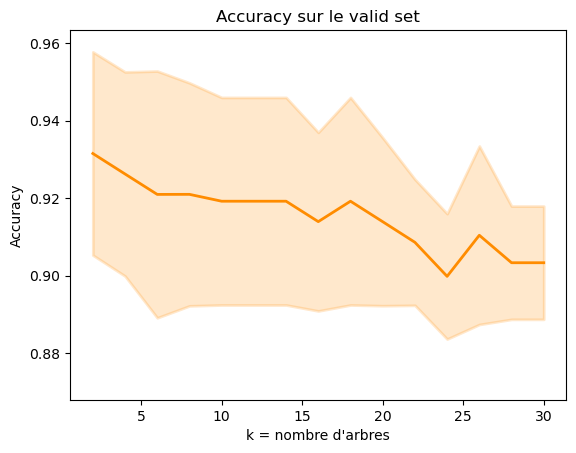

In [13]:
max_i = 0
max_acc = 0
min_acc = 1
mean_acc = []
std_acc = []
count=0
for i in range(2,p,2):
    new_acc = np.mean(acc[count])
    mean_acc.append(new_acc)
    new_std = np.std(acc[count])
    std_acc.append(new_std)
    if new_acc > max_acc:
        max_i = i
        max_acc = new_acc
    if new_acc < min_acc:
        min_acc = new_acc
    count+=1
print("\n\nMeilleur dimension = %3.0f Accuracy moyenne = %0.3f"%(max_i, max_acc))

mean_acc = np.double(mean_acc)
std_acc = np.double(std_acc)
plt.title("Accuracy sur le valid set")
plt.xlabel("k = nombre d'arbres")
plt.ylabel("Accuracy")
plt.ylim(min_acc - np.max(std_acc), max_acc + np.max(std_acc))
lw = 2
param_range = range(2,p,2)
plt.plot(
    param_range, mean_acc, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    mean_acc - std_acc,
    mean_acc + std_acc,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)

La meilleure valeur de *nb_dimensions* semble être 2 ce qui est encore une fois assez loin de $\frac{p}{2}=15$. Cependant la valeur de ce paramètre n'a pas une importance aussi significative que dans le cas précédent car les variations de l'accuracy sont moins prononcées.